# EDA project

## Load libraries and datasets

In [177]:
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency


In [203]:
clients_raw = pd.read_csv('../data/df_final_demo.txt')
events_1_raw = pd.read_csv('../data/df_final_web_data_pt_1.txt')
events_2_raw = pd.read_csv('../data/df_final_web_data_pt_2.txt')
test_raw = pd.read_csv('../data/df_final_experiment_clients.txt')

## Data cleaning and exploration

### Clients

In [204]:
clients = clients_raw.copy()
clients.head()

,client_id,clnt_tenure_yr,clnt_tenure_mnth,clnt_age,gendr,num_accts,bal,calls_6_mnth,logons_6_mnth
0,836976,6.0,73.0,60.5,U,2.0,45105.30,6.0,9.0
1,2304905,7.0,94.0,58.0,U,2.0,110860.30,6.0,9.0
2,1439522,5.0,64.0,32.0,U,2.0,52467.79,6.0,9.0
3,1562045,16.0,198.0,49.0,M,2.0,67454.65,3.0,6.0
4,5126305,12.0,145.0,33.0,F,2.0,103671.75,0.0,3.0


In [180]:
clients.info()
# there are some null values. 
# client_id and gender are the only categorical columns. 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70609 entries, 0 to 70608
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         70609 non-null  int64  
 1   clnt_tenure_yr    70595 non-null  float64
 2   clnt_tenure_mnth  70595 non-null  float64
 3   clnt_age          70594 non-null  float64
 4   gendr             70595 non-null  object 
 5   num_accts         70595 non-null  float64
 6   bal               70595 non-null  float64
 7   calls_6_mnth      70595 non-null  float64
 8   logons_6_mnth     70595 non-null  float64
dtypes: float64(7), int64(1), object(1)
memory usage: 4.8+ MB


In [181]:
# remove null values

clients.isnull().sum().sort_values(ascending = False)
clients[clients.clnt_age.isna()]

# it seems like there are 14 rows with lots of null values and 1 row where the age is missing. 
# This is an insignificant amount of data (having >70000 valid data points) 
# We can savely remove these data. 

clients.dropna(inplace=True)

In [182]:
# look for duplicates
clients.duplicated().sum()

# there are no duplicated values. 

np.int64(0)

In [183]:
# assign correct data types

clients.dtypes

# create 2 lists for categorial vs numerical columns. 
clients_num = list(clients.select_dtypes("number").columns)
clients_num.remove('client_id')
clients_cat = ['client_id', 'gendr']

len(clients.columns) == len (clients_num + clients_cat)

# many numerical columns look like int but have type float. Let's assign the correct type.
int_cols = ['clnt_tenure_yr', 'clnt_tenure_mnth', 'num_accts', 'calls_6_mnth', 'logons_6_mnth']
clients[int_cols] = clients[int_cols].astype('int64')


In [184]:
# Explore categorial columns. 
# there are for possible values for gender. We assume that 'U' stands for unknown. 'X' may stand for non binary. 
clients.gendr.value_counts()

gendr
U    24122
M    23724
F    22745
X        3
Name: count, dtype: int64

In [185]:
# Explore numerical columns. 

clients[clients_num].describe()

,clnt_tenure_yr,clnt_tenure_mnth,clnt_age,num_accts,bal,calls_6_mnth,logons_6_mnth
count,70594.000000,70594.000000,70594.000000,70594.000000,7.059400e+04,70594.000000,70594.000000
mean,12.053007,150.659999,46.442240,2.255532,1.474467e+05,3.382469,5.566720
std,6.871850,82.090264,15.591273,0.535000,3.015106e+05,2.236595,2.353296
min,2.000000,33.000000,13.500000,1.000000,1.378942e+04,0.000000,1.000000
25%,6.000000,82.000000,32.500000,2.000000,3.734660e+04,1.000000,4.000000
50%,11.000000,136.000000,47.000000,2.000000,6.333459e+04,3.000000,5.000000
75%,16.000000,192.000000,59.000000,2.000000,1.375461e+05,6.000000,7.000000
max,62.000000,749.000000,96.000000,8.000000,1.632004e+07,7.000000,9.000000


### Events

In [186]:
# there are two datasets for events. We want to merge them. 
events_1_raw.shape
events_2_raw.shape

# both columns have the same columns, we can savely concat them.
events = pd.concat([events_1_raw, events_2_raw])
events.head()

,client_id,visitor_id,visit_id,process_step,date_time
0,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:27:07
1,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:26:51
2,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:19:22
3,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:19:13
4,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:18:04


In [187]:
events.info()
# the column types seem more or less correct and there are no null values. 

<class 'pandas.core.frame.DataFrame'>
Index: 755405 entries, 0 to 412263
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   client_id     755405 non-null  int64 
 1   visitor_id    755405 non-null  object
 2   visit_id      755405 non-null  object
 3   process_step  755405 non-null  object
 4   date_time     755405 non-null  object
dtypes: int64(1), object(4)
memory usage: 34.6+ MB


In [188]:
# remove duplicates. 

events.duplicated().sum()   
# there are many duplicated events. Let's remove them
events.drop_duplicates(inplace=True)

In [189]:
# data types. 
events_categorical = ['client_id', 'visitor_id', 'visit_id', 'process_step']

# ordinal: process_step
events_numerical = ['date_time']

# let's convert date_time to datetime. 
events['date_time'] = pd.to_datetime(events['date_time'])

In [190]:
# categorial columns exploration.
events['process_step'].value_counts()

process_step
start      234999
step_1     162797
step_2     132750
step_3     111589
confirm    102506
Name: count, dtype: int64

In [191]:
events_categorical = ['client_id', 'visitor_id', 'visit_id', 'process_step']
# ordinal: process_step
events_numerical = ['date_time']

### Test

In [192]:
test = test_raw.copy()
test.head()

,client_id,Variation
0,9988021,Test
1,8320017,Test
2,4033851,Control
3,1982004,Test
4,9294070,Control


In [193]:
test.info()

# there are null values in the 'Variation' column. We assume these clients didn't participate in the experiment.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70609 entries, 0 to 70608
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   client_id  70609 non-null  int64 
 1   Variation  50500 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


In [194]:
# remove nulls. 
# we will remove the clients that didn't participate in the experiment.
test = test.dropna()

In [196]:
test

,client_id,Variation,test
0,9988021,Test,True
1,8320017,Test,True
2,4033851,Control,False
3,1982004,Test,True
4,9294070,Control,False
...,...,...,...
50495,393005,Control,False
50496,2908510,Control,False
50497,7230446,Test,True
50498,5230357,Test,True


## Univariate Analysis

### Clients

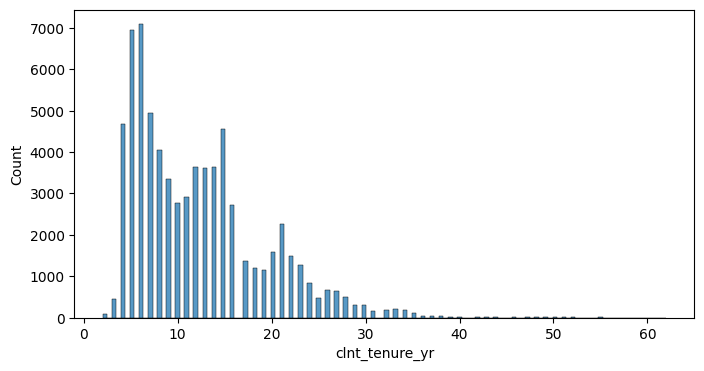

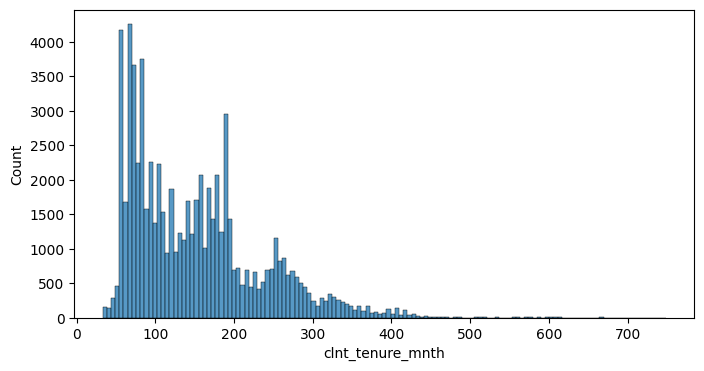

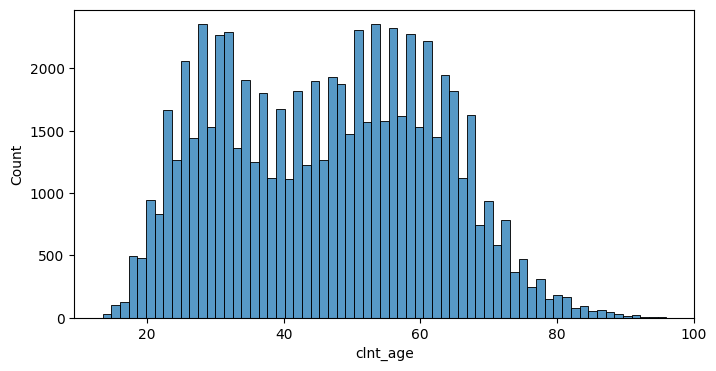

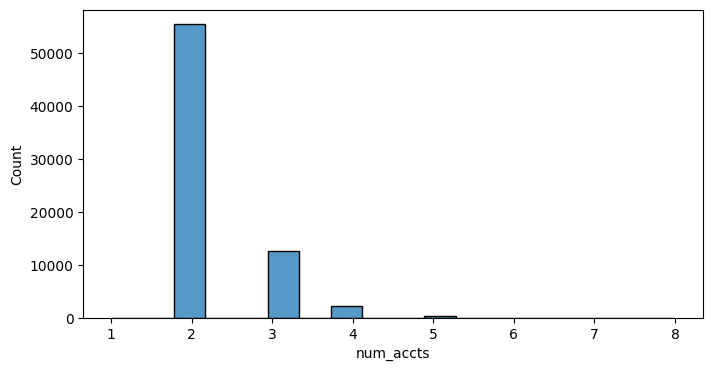

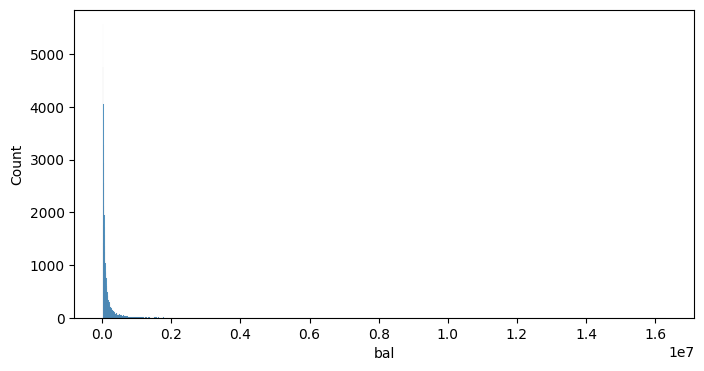

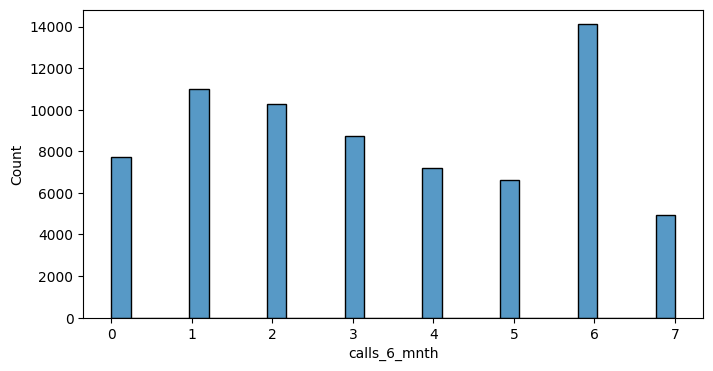

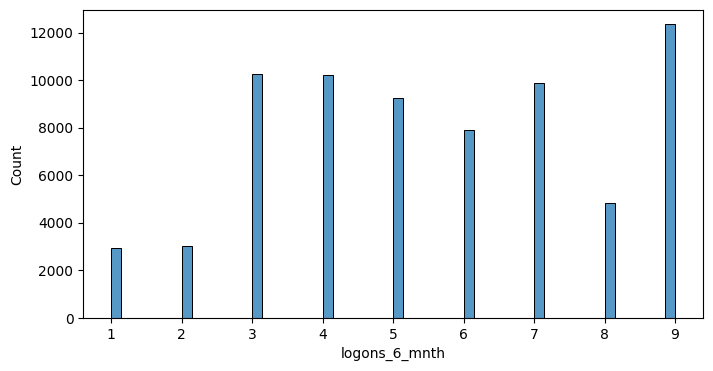

In [130]:
# visualise distributions for numerical columns.  

for col in clients_num:
    plt.figure(figsize=(8, 4))
    sns.histplot(x=clients[col])
    plt.show()


/var/folders/yf/ydfr37g56sb7b4mncpm76gk00000gn/T/ipykernel_43952/3211288094.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(c['bal'], color='skyblue', shade=True)


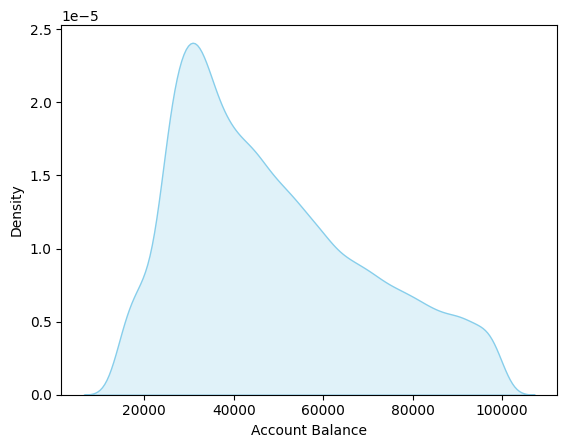

In [131]:
c = clients[clients['bal']<100000]
sns.kdeplot(c['bal'], color='skyblue', shade=True)
plt.xlabel('Account Balance')
plt.show()

### Events

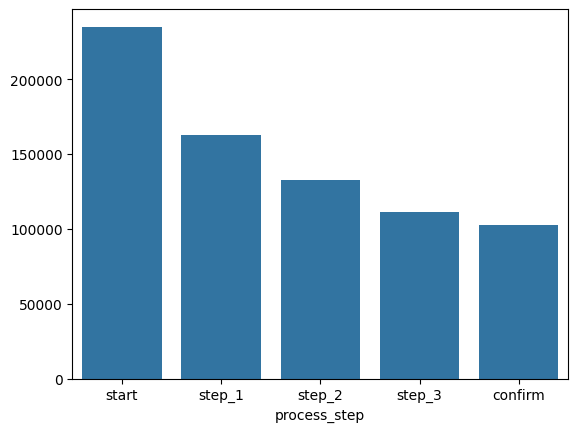

In [132]:
# Let's see how far in the funnel the users get

frequency_table = events["process_step"].value_counts()
frequency_table 

sns.barplot(x=frequency_table.index, y=frequency_table.values);

plt.show()

### Most active clients

In [133]:
# We will count the number of events to identify the most active clients. 

client_event_counts = events['client_id'].value_counts()
clients_events = pd.merge(clients, client_event_counts, on="client_id", how="inner")

In [101]:
# Identify the top 10% of active clients (this can be changed to any other percentage if needed)
top_clients = client_event_counts.head(int(len(client_event_counts) * 0.10))

# Get the demographic information of these top clients
top_client_info = clients[clients['client_id'].isin(top_clients.index)]

print(f"Number of most active clients: {len(top_client_info)}")
top_client_info

Number of most active clients: 5273


,client_id,clnt_tenure_yr,clnt_tenure_mnth,clnt_age,gendr,num_accts,bal,calls_6_mnth,logons_6_mnth
0,836976,6,73,60.5,U,2,45105.30,6,9
26,9381346,7,88,62.5,U,2,272252.76,0,3
28,3055315,5,65,34.5,F,2,66560.69,1,5
35,2305285,14,168,54.0,M,2,132347.89,6,9
37,3065089,19,228,63.0,M,2,439723.43,6,9
...,...,...,...,...,...,...,...,...,...
50479,1738333,7,90,68.5,U,2,341777.81,3,6
50480,1624825,16,195,63.5,F,2,106532.51,3,6
50482,9677776,5,70,64.5,U,2,57398.19,1,4
50485,3823121,14,178,68.5,F,2,32666.22,6,9


In [91]:
age_analysis = top_client_info['clnt_age'].describe()
tenure_years_analysis = top_client_info['clnt_tenure_yr'].describe()
tenure_months_analysis = top_client_info['clnt_tenure_mnth'].describe()

print("Age Analysis:\n", age_analysis)
print("\nTenure (Years) Analysis:\n", tenure_years_analysis)
print("\nTenure (Months) Analysis:\n", tenure_months_analysis)

Age Analysis:
 count    5273.000000
mean       52.714204
std        15.359438
min        17.500000
25%        42.000000
50%        55.500000
75%        64.000000
max        94.000000
Name: clnt_age, dtype: float64

Tenure (Years) Analysis:
 count    5273.000000
mean       12.845060
std         7.310043
min         2.000000
25%         7.000000
50%        12.000000
75%        17.000000
max        55.000000
Name: clnt_tenure_yr, dtype: float64

Tenure (Months) Analysis:
 count    5273.000000
mean      160.099374
std        87.445324
min        34.000000
25%        84.000000
50%       145.000000
75%       213.000000
max       668.000000
Name: clnt_tenure_mnth, dtype: float64


/var/folders/yf/ydfr37g56sb7b4mncpm76gk00000gn/T/ipykernel_43952/4103859942.py:1: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(clients['clnt_age'], color='skyblue', shade=True)


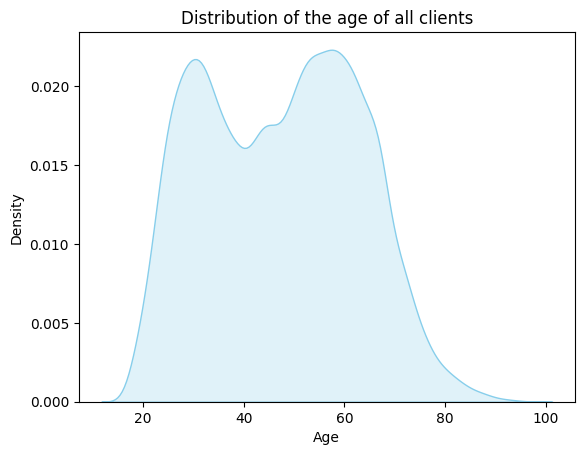

/var/folders/yf/ydfr37g56sb7b4mncpm76gk00000gn/T/ipykernel_43952/4103859942.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(top_client_info['clnt_age'], color='skyblue', shade=True)


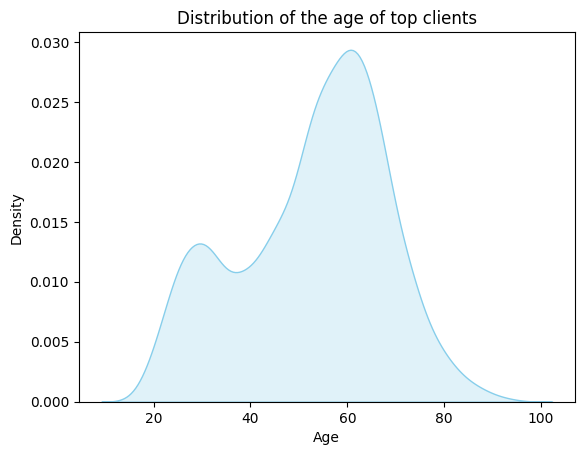

In [92]:
sns.kdeplot(clients['clnt_age'], color='skyblue', shade=True)
plt.xlabel('Age')
plt.title('Distribution of the age of all clients')
plt.show()
sns.kdeplot(top_client_info['clnt_age'], color='skyblue', shade=True)
plt.xlabel('Age')
plt.title('Distribution of the age of top clients')
plt.show()

C:\Users\Lidia Mayor\AppData\Local\Temp\ipykernel_15796\1122749775.py:1: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(clients['clnt_tenure_yr'], color='skyblue', shade=True)


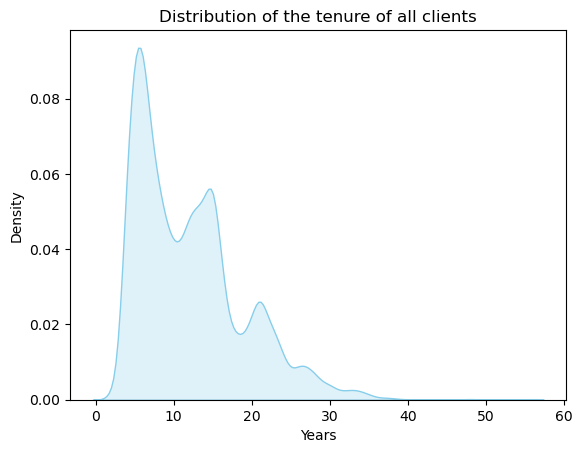

C:\Users\Lidia Mayor\AppData\Local\Temp\ipykernel_15796\1122749775.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(top_client_info['clnt_tenure_yr'], color='skyblue', shade=True)


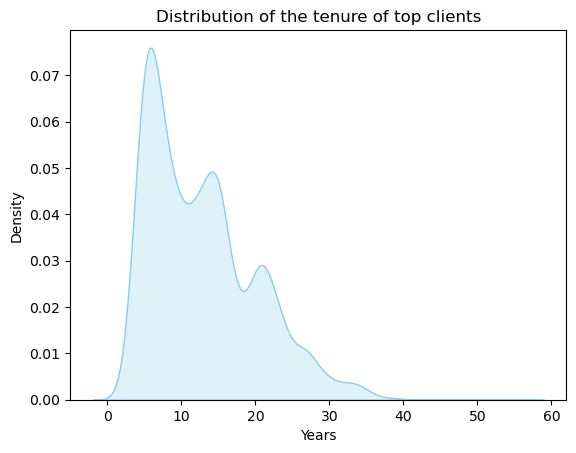

In [94]:
sns.kdeplot(clients['clnt_tenure_yr'], color='skyblue', shade=True)
plt.xlabel('Years')
plt.title('Distribution of the tenure of all clients')
plt.show()
sns.kdeplot(top_client_info['clnt_tenure_yr'], color='skyblue', shade=True)
plt.xlabel('Years')
plt.title('Distribution of the tenure of top clients')
plt.show()

C:\Users\Lidia Mayor\AppData\Local\Temp\ipykernel_15796\3245863311.py:1: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(top_client_info['clnt_tenure_mnth'], color='skyblue', shade=True)


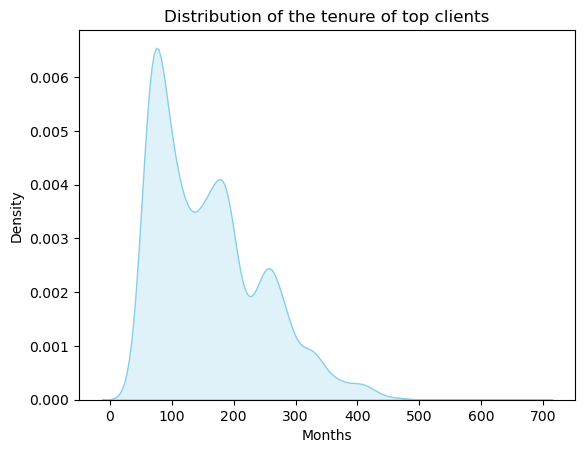

In [99]:
sns.kdeplot(top_client_info['clnt_tenure_mnth'], color='skyblue', shade=True)
plt.xlabel('Months')
plt.title('Distribution of the tenure of top clients')
plt.show()

In [89]:
balance_analysis = top_client_info['bal'].describe()
calls_analysis = top_client_info['calls_6_mnth'].describe()
logons_analysis = top_client_info['logons_6_mnth'].describe()

print("Balance Analysis:\n", balance_analysis)
print("\nCalls (Last 6 Months) Analysis:\n", calls_analysis)
print("\nLogons (Last 6 Months) Analysis:\n", logons_analysis)

Balance Analysis:
 count    5.048000e+03
mean     1.910168e+05
std      3.996731e+05
min      2.378961e+04
25%      4.568401e+04
50%      8.175343e+04
75%      1.919637e+05
max      1.632004e+07
Name: bal, dtype: float64

Calls (Last 6 Months) Analysis:
 count    5048.000000
mean        3.597068
std         2.181048
min         0.000000
25%         2.000000
50%         4.000000
75%         6.000000
max         6.000000
Name: calls_6_mnth, dtype: float64

Logons (Last 6 Months) Analysis:
 count    5048.000000
mean        6.637480
std         2.161619
min         3.000000
25%         5.000000
50%         7.000000
75%         9.000000
max         9.000000
Name: logons_6_mnth, dtype: float64


In [90]:
# Insights Summary
print("Key Insights:")
print(f"The primary clients using the online process have an average age of {age_analysis['mean']} years.")
print(f"These clients have an average tenure of {tenure_years_analysis['mean']} years and {tenure_months_analysis['mean']} months.")
print(f"On average, these clients have an account balance of {balance_analysis['mean']} and log in {logons_analysis['mean']} times in the last 6 months.")
print(f"Additionally, they make an average of {calls_analysis['mean']} calls in the last 6 months.")


Key Insights:
The primary clients using the online process have an average age of 52.765649762282095 years.
These clients have an average tenure of 12.803882725832013 years and 159.60360538827257 months.
On average, these clients have an account balance of 191016.80021394612 and log in 6.637480190174326 times in the last 6 months.
Additionally, they make an average of 3.597068145800317 calls in the last 6 months.


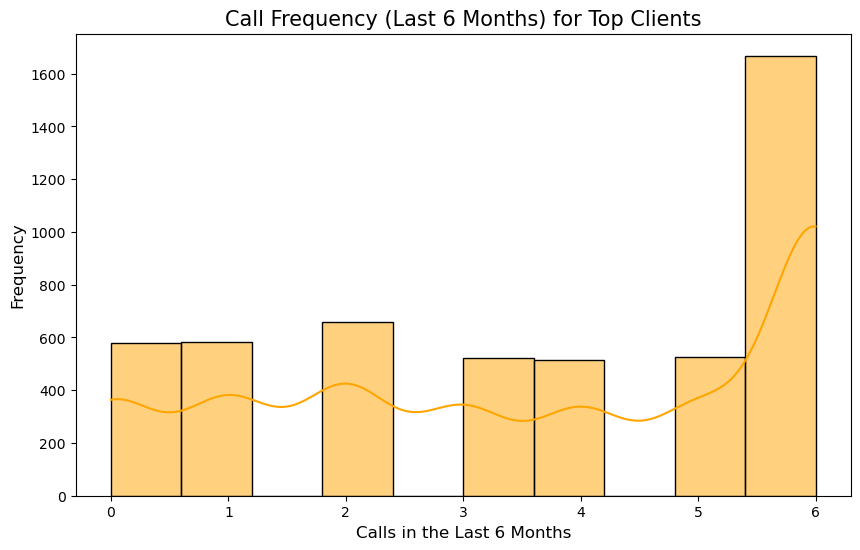

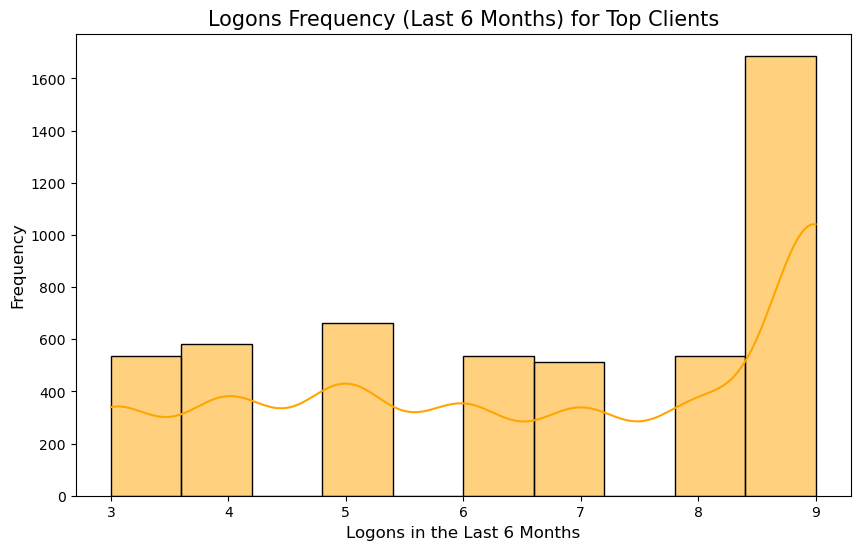

In [148]:
# Plot call frequency distribution for top clients
plt.figure(figsize=(10, 6))
sns.histplot(top_client_info['calls_6_mnth'], bins=10, kde=True, color='orange')
plt.title('Call Frequency (Last 6 Months) for Top Clients', fontsize=15)
plt.xlabel('Calls in the Last 6 Months', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(top_client_info['logons_6_mnth'], bins=10, kde=True, color='orange')
plt.title('Logons Frequency (Last 6 Months) for Top Clients', fontsize=15)
plt.xlabel('Logons in the Last 6 Months', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

In [163]:
# Merge the events DataFrame with the test DataFrame to get the 'Variation' (Test/Control) for each client
events_test_control = pd.merge(events, test, on='client_id', how='inner')

# Group by the 'Variation' column and count the number of events for each group
event_counts = events_test_control.groupby('Variation').size().reset_index(name='event_count')
event_counts

,Variation,event_count
0,Control,140536
1,Test,176699


## Behavior analysis

In [198]:
# turn the step column into a numeric value. 
events['num_step'] = events['process_step'].replace({'start': 0, 'step_1': 1, 'step_2': 2, 'step_3': 3, 'confirm': 4})

# calculate conversion column for each client
events['conversion'] = events.groupby('client_id')['process_step'].transform(lambda x: int('confirm' in x.values))

# add conversion info to test df 
test = pd.merge(test, events[['client_id','conversion']].groupby('client_id').first(), on='client_id', how='left')

test

/var/folders/yf/ydfr37g56sb7b4mncpm76gk00000gn/T/ipykernel_43952/1355186731.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  events['num_step'] = events['process_step'].replace({'start': 0, 'step_1': 1, 'step_2': 2, 'step_3': 3, 'confirm': 4})


,client_id,Variation,test,conversion
0,9988021,Test,True,0
1,8320017,Test,True,1
2,4033851,Control,False,1
3,1982004,Test,True,1
4,9294070,Control,False,0
...,...,...,...,...
50495,393005,Control,False,1
50496,2908510,Control,False,0
50497,7230446,Test,True,0
50498,5230357,Test,True,1


In [199]:
crosstab_result = pd.crosstab(test['Variation'], test['conversion'])

crosstab_result

conversion,0,1
Variation,,
Control,8098,15434
Test,8281,18687


In [200]:

# Chi-square test for 'MSZoning' and 'SaleCondition'
chi2_statistic, chi2_p_value, _, _ = chi2_contingency(crosstab_result)

chi2_statistic, chi2_p_value
chi2_p_value < 0.05

(np.float64(78.5879813123307), np.float64(7.651350968671897e-19))

In [ ]:
clients_reached = pd.merge(clients_reached, test, on='client_id', how='inner')

In [ ]:
events_shift = events.copy()
events_shift[['end_time', 'next_step']] = events_shift[['visit_id', 'date_time','num_step']].groupby('visit_id').shift(1)
events_shift = events_shift.rename(columns={'date_time':'init_time', 'num_step':'init_step'})
new_orden = ['client_id', 'visitor_id', 'visit_id', 'process_step', 'init_time', 'end_time', 'init_step', 'next_step', 'reached_confirm']
events_shift= events_shift[new_orden]
events_shift = events_shift.dropna()
events_shift['next_step'] = events_shift['next_step'].astype(int)
events_shift['time_spend'] = (events_shift['end_time']-events_shift['init_time']).dt.total_seconds()
events_shift.head()

In [174]:
# Plot the number of events for Test vs Control groups
plt.figure(figsize=(8, 5))
sns.barplot(x='Variation', y='event_count', data=event_counts, palette='Set2')
plt.title('Number of Events by Test/Control Group', fontsize=15)
plt.xlabel('Group', fontsize=12)
plt.ylabel('Number of Events', fontsize=12)
plt.xticks([0, 1], ['Control', 'Test'])
plt.show()

NameError: name 'event_counts' is not defined

<Figure size 800x500 with 0 Axes>